##**1. Importing the necessary libraries.**

In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
import plotly.express as px
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
from matplotlib import pyplot
import pickle
from sklearn.metrics import accuracy_score
from scipy import integrate
import interpret
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret import show
import pickle

##**2. From the initial data towards the final dataset**

We had at our disposal meteorological, satellite and trap related data. Each set of data as well as all the data combined, underwent some preprocessing and feature engineering. 

**2.1 The meteorological data**

  In real life scenarios, exact weather
conditions are very hard to obtain. This is true due to the
absence of a dense network of weather stations. To overcome
this, we use numerical weather predictions using our own
configuration of WRF-ARW. The model is of high
spatial resolution (2 km), and predictions are made hourly. For each trap location, we obtained daily values for air (2 m) and 
soil temperature (0 m), relative humidity (RH), accumulated
precipitation (AP), dew point (DP), and wind speed (WS).
These parameters have been extensively used in related work.

  Having this information at our disposal, we procceded by keeping daily minimum and maximum values for each parameter mentioned. Besides that, we also did some accumulations (in a time range of 7 days) to capture the time fluctuations of these variables. Finally, using temperature we calculated growing degree days(GDD) which capture the effective growth time of the plant, according to the equation: 

$$GDD = \max\left({\frac{T_{max}+T_{min}}{2}-T_{base},0}\right)$$

Where $T_{base} = 15.6^{\circ}$ for cotton.

**2.2 The satellite data**

We used Sentinel-2 images to capture the
vegetation status (at the location of the traps) and its evolution
through time. Using atmospherically corrected Sentinel-
2 images, we calculated a number of vegetation indices that
highlight particular characteristics of the crops (e.g., mois-
ture, physiological stress etc.) that are known to i) drive
the occurrence of pests, but also ii) capture the vegetation
cover changes caused by the insects. In detail, we used
the normalized difference vegetation (NDVI), water (NDWI),
moisture (NDMI), greenness (GI) and greenness chlorophyll
(GCVI) indices.

$NDVI = \frac{NIR-RED}{NIR+RED}$

NDVI is the most common vegetation index in remote sensing. It can be used throughout the whole crop production season except when vegetation cover is too scarce, so its spectral reflectance is too low. NDVI values are the most accurate in the middle of the season at the stage of active crop growth.

$NDWI = \frac{GREEN-NIR}{GREEN+NIR}$

The water in the internal leaf structure impacts the spectral reflectance in SWIR. NDWI aids in the detection of flooded agricultural lands; allocation of flooding on the field, detection irrigated farmland; allocation of wetlands.

$NDMI = \frac{NIR-SWIR}{NIR+SWIR}$

The Normalized Difference Moisture Index (NDMI) detects moisture levels in vegetation.

 $GI = \frac{2*GREEN-RED-BLUE}{2*GREEN+RED+BLUE}$

GI allows us to study the seasonality of vegetation growth, measure vegetation health, and assess whether an area has green vegetation or not.

 $GCVI = \frac{NIR}{GREEN}-1$

Better prediction of chlorophyll amount with the GCVI vegetation index can be achieved by using satellite sensors that have broad NIR and green wavelengths.
It is used to monitor the impact of seasonality, environmental stresses, or applied pesticides on vegetation health.

All the above values were transformed using the cumulative trapezoid integration rule. 

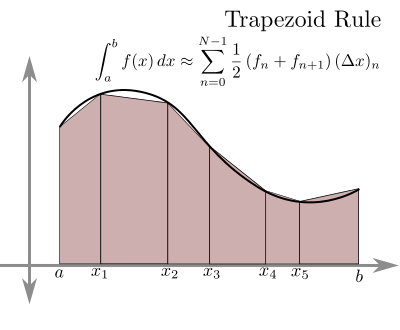

**2.3 The trap related data**

To obtain insect population measurements, we collaborated with the company Corteva Agriscience Hellas that has a trap network for helicoverpa armigera. The network consists of pheromone traps in 26 different locations in the wider
region of Central Macedonia, Greece. The traps are located in such a distance so as to not interact with each other and are examined (trapped insect counting) by a specialist every 3-5 days. The observations take place from June 2020 until early September 2020 and June 2021 until early September 2021. The trap data include i) the trap locations, ii) the number of pests on each trap and iii) the Day of Year (DoY) they were recorded. In total, there are 10 locations for 2021 and 16 locations for 2020. Therefore, we had the trap coordinates and the time series of insect measurements. 

Using the trap coordinates we downloaded the satellite data. We had at our disposal the trap catches, we created 3 new variables measuring past 3, 2 and 1 catches. The trap catches were binarized according to an action threshold using the function *tarnsform_labels*: 

In [ ]:
def transform_labels(y):
    new_labels = []
    for yy in y: 
        if yy > 10:
            a = 1
        else:
            a = 0 
        #print(a)
        new_labels.append(a)
    return new_labels

To have the data on the same scale we standardized using a standard scaler.

$z =  \frac{x-μ}{σ}$, where $μ$ = mean and $σ$ = standard deviation

Now we are going to load the data from drive #add command to mount drive 

**3. Problem formulation**

Let $T$ be the set of traps we have at our disposal. We note as $t_{ij}\in T$ the entity describing trap $i$ on date $j$. Every $t_{ij}$ can be expressed as
$t_{ij} = (x_{ij},y_{ij})$, where $x_{ij}\in{\rm I\!R^{d}}$ is a $d$ dimensional vector containing the corresponding weather and satellite features, and $y_{ij}\in\{0, 1\}$, with $0$ referring to pest absence and $1$ referring to pest presence. Our aim is to find a model $M:{\rm I\!R^{d}} \rightarrow \{0, 1\} $, so that for any trap $t_{ij}$, to predict the onset of harmful presence of bollworm population that will in turn signal the time for intervention. 

**4. Explainable classifier approach**

The model we used is the Explainable Boosting Machine (EBM), as implemented in the InterpretML framework. In machine learning, there is often a trade-off between accuracy and intelligibility. This is not true for EBM that achieves a performance comparable to powerful black-box models, while offering global and local explanations on the predictions. EBM is an augmented version of the Generalized Additive Models (GAMs), which are expressed by:

$g(E(y)) = \beta_{0} + \sum{f_j(x_j)}$

In practice, EBM is a GAM model with interactions based on the GA2M method, expressed by:

$g(E(y)) = \beta_{0} + \sum{f_j(x_j)} + \sum{f_{ij}(x_i,x_j)}$

Every feature function $f_{j}$ is learnt using many shallow decision trees. The learning is achieved using one predictive feature at a time in round-robin pass over the train data, while performing gradient updates. In more detail, we train a tree on the first feature, then in boosting fashion we update the residual and move to the second feature, then we train another tree and so on. 

All features' contributions, together with the interactions, yield a logit score. Scores are then summed and passed to the link function $g$, which is chosen depending on the context. In binary classification, as in our case, EBM uses the logarithmic loss. Since the model is additive, the contributions of the terms can be sorted and visualized.

**5. InterpretML part**

In [ ]:
import interpret
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret import show

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Earth observation and machine learning for agroecological applications 

Mounted at /content/drive
/content/drive/My Drive/Earth observation and machine learning for agroecological applications


In [ ]:
final_data = pd.read_csv('without_trap_info.csv')

In [ ]:
new_data = final_data.dropna()
y = new_data['Catches']
#y_trf = transform_labels(y)

data = new_data.copy()
data.drop( ['Catches'], inplace=True, axis=1) 
data.drop( ['Unnamed: 0'], inplace=True, axis=1) 

X = data

In [ ]:
#scaling and labels transformation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
sc = preprocessing.StandardScaler()
X_trs = sc.fit_transform(X_train)
X_ts = sc.transform (X_test)
ytrf = transform_labels(y_train)
ytsf = transform_labels(y_test)

In [ ]:
ebm = ExplainableBoostingClassifier(feature_names=['ndvi', 'ndwi', 'ndmi', 'gi',
        'gcvi', 'Temp2_min_acc',
       'Temp2_min', 'Temp2_max_acc', 'Temp2_max', 'Temp0_min_acc', 'Temp0_min',
       'Dew_point_min', 'Dew_point_max', 'Wind_speed_min', 'Wind_speed_max',
       'Temp0_max_acc', 'RH_min_acc', 'Temp0_max', 'APCP_acc', 'GDD', 'sinDOY',
       'cosDOY', 'RH_max_acc', 'RH_min', 'RH_max', 'APCP'],
        feature_types=['continuous', 'continuous','continuous','continuous',
                       'continuous','continuous','continuous','continuous',
                       'continuous','continuous','continuous','continuous',
                       'continuous','continuous','continuous','continuous',
                       'continuous','continuous','continuous','continuous','continuous',
                      'continuous','continuous','continuous','continuous','continuous'
                      ,'continuous','continuous','continuous','continuous','continuous','continuous','continuous'
                      'continuous','continuous','continuous','continuous','continuous'],random_state=42)
ebm.fit(X_trs, ytrf)

ExplainableBoostingClassifier(feature_names=['ndvi', 'ndwi', 'ndmi', 'gi',
                                             'gcvi', 'Temp2_min_acc',
                                             'Temp2_min', 'Temp2_max_acc',
                                             'Temp2_max', 'Temp0_min_acc',
                                             'Temp0_min', 'Dew_point_min',
                                             'Dew_point_max', 'Wind_speed_min',
                                             'Wind_speed_max', 'Temp0_max_acc',
                                             'RH_min_acc', 'Temp0_max',
                                             'APCP_acc', 'GDD', 'sinDOY',
                                             'cosDOY', 'RH_max_acc', 'RH_min',
                                             'RH_max', 'APCP',
                                             'gcvi x Wi...
                                             'continuous', 'continuous',
                                             'cont

In [ ]:
ypred = ebm.predict(X_ts) #Let's predict!

In [ ]:
# How did our model perform?
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
classif_dict = classification_report(ytsf, ypred, target_names=target_names,output_dict=True)
print(classification_report(ytsf, ypred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.68      0.67      0.67        54
     class 1       0.66      0.67      0.67        52

    accuracy                           0.67       106
   macro avg       0.67      0.67      0.67       106
weighted avg       0.67      0.67      0.67       106



In [ ]:
from interpret import show
import dash
from dash import*

# Let's see which features affected the result...
ebm_global = ebm.explain_global()
show(ebm_global)

/usr/local/lib/python3.7/dist-packages/interpret/provider/visualize.py:44: UserWarning: Cloud environment detected (['colab', 'ipython']): viz integration is still experimental.
  detected_envs


**5.1 Leaving one trap out**

In [ ]:
#loading the necessary data 

In [ ]:
new_data = pd.read_csv('new_without_trap_info.csv')
X_test = pd.read_csv('new_test.csv')
y_test = pd.read_csv('y_test.csv')
y_train = pd.read_csv('y_train.csv')
test_location = pd.read_csv('new_test_location.csv')

In [ ]:
result = {}

In [ ]:
X_train = new_data #all the other traps are the training data

sc = preprocessing.StandardScaler()
X_trs = pd.DataFrame(sc.fit_transform(X_train), columns = X_train.columns)
X_ts = pd.DataFrame(sc.transform(X_test), columns = X_test.columns)
ytrf = transform_labels(y_train['Catches'])
ytsf = transform_labels(y_test['Catches'])

new_model = ExplainableBoostingClassifier(feature_names = ['ndvi', 'ndwi', 'ndmi', 'gi',
            'gcvi', 'Temp2_min_acc',
           'Temp2_min', 'Temp2_max_acc', 'Temp2_max', 'Temp0_min_acc', 'Temp0_min',
           'Dew_point_min', 'Dew_point_max', 'Wind_speed_min', 'Wind_speed_max',
           'Temp0_max_acc', 'RH_min_acc', 'Temp0_max', 'APCP_acc', 'GDD', 'sinDOY',
           'cosDOY', 'RH_max_acc', 'RH_min', 'RH_max', 'APCP'],
            feature_types=['continuous', 'continuous','continuous','continuous',
                           'continuous','continuous','continuous','continuous',
                           'continuous','continuous','continuous','continuous',
                           'continuous','continuous','continuous','continuous',
                           'continuous','continuous','continuous','continuous','continuous',
                          'continuous','continuous','continuous','continuous','continuous'
                          ,'continuous','continuous','continuous','continuous','continuous','continuous','continuous'
                          'continuous','continuous','continuous','continuous','continuous'],random_state=42)
new_model.fit(X_trs, ytrf)
ybm = new_model.predict(X_ts)
print(ybm)
target_names = ['class 0', 'class 1']
classif_dict = classification_report(ytsf, ybm, target_names=target_names,output_dict=True)
#print(classification_report(ytsf, ybm, target_names=target_names))
result['y_true'] = list(y_test['Catches'])
result['y_pred'] = list(ybm)
result['report'] = classif_dict 

[0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0]


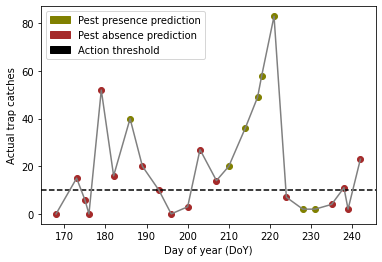

In [ ]:
preds = transform_labels(result['y_pred'])
test_location.dropna(subset=['Manual_measures'],inplace=True)
#test_location['Date']=test_location['Date'].dt.dayofyear

vals = list(result['y_true'])
preds = list(result['y_pred'])
inds = list(test_location['Date'])



import matplotlib.patches as mpatches
fig, ax = plt.subplots()
red_patch = mpatches.Patch(color='black', label='Action threshold')
green_patch = mpatches.Patch(color='olive', label='Pest presence prediction')
lred_patch = mpatches.Patch(color='brown', label='Pest absence prediction')
ax.legend(handles=[green_patch,lred_patch,red_patch])

plt.axhline(y=10, color='black', linestyle='dashed')
for i,p in enumerate(preds):
    if p == 1:
        c='olive'
    else:
        c='brown'
    plt.scatter(inds[i],vals[i],color=c)
plt.plot(inds,vals,color='grey')
plt.xlabel("Day of year (DoY)")
plt.ylabel("Actual trap catches")
plt.show()

In [ ]:
# What is happening on the local side?

In [ ]:
ebm_local = new_model.explain_local(X_ts,ytsf)
show(ebm_local)